In [2]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.models import vgg16

In [3]:
import cv2
from glob import glob
from tqdm import tqdm


In [4]:
birdspath='./Parsed_Capuchinbird_Clips/*'
nobirdspath='./Parsed_Not_Capuchinbird_Clips/*'

In [5]:
len(glob(birdspath))

217

In [6]:
len(glob(nobirdspath))
birdspaths=glob(birdspath)
nobirdspaths=glob(nobirdspath)

In [7]:
import torchaudio

In [8]:
glob(birdspath)[0]

'./Parsed_Capuchinbird_Clips/XC388470-3.wav'

In [9]:
torchaudio.set_audio_backend("soundfile")

/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_33275/1822137616.py:1: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [10]:
import torchaudio
torchaudio.set_audio_backend("soundfile")

waveform, sample_rate = torchaudio.load(birdspaths[4])

/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_33275/1775473697.py:2: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [11]:
import torchaudio
print(torchaudio.get_audio_backend())

None


/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_33275/145563050.py:2: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  print(torchaudio.get_audio_backend())


In [12]:
%pip install soundfile

Note: you may need to restart the kernel to use updated packages.


In [13]:
torchaudio.get_audio_backend()

/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_33275/1746710290.py:1: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.get_audio_backend()


In [14]:
waveform,sample_rate=torchaudio.load(glob(birdspath)[10])
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0)  # shape: [num_samples]

# Add batch dimension only
waveform = waveform.unsqueeze(0) 

In [15]:
waveform.shape

torch.Size([1, 1, 132300])

In [16]:
sample_rate

44100

In [17]:
spectrogram_transform = torchaudio.transforms.Spectrogram(
    n_fft=1024,       
    win_length=None,  
    hop_length=512,   
    power=2.0       
)

In [18]:
wave=spectrogram_transform(waveform).shape


In [19]:
import matplotlib.pyplot as plt

In [20]:
device='mps' if torch.backends.mps.is_available() else 'cpu'

In [21]:
def convertembeddings(waveform):
    """Convert audio waveform to embeddings using WavLM"""
    # Load pretrained model
    bundle = torchaudio.pipelines.WAVLM_BASE
    model = bundle.get_model().to(device)
    model.eval()
    
    # Ensure waveform is on the correct device and has correct shape
    waveform = waveform.to(device)
    
    # Convert to mono if stereo
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    
    # Ensure waveform has shape [batch, time]
    if waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    
    # Resample if needed
    if bundle.sample_rate != 16000:  # Assuming original is 16kHz
        resampler = torchaudio.transforms.Resample(
            orig_freq=16000, 
            new_freq=bundle.sample_rate
        ).to(device)
        waveform = resampler(waveform)
    
    # Extract features
    with torch.inference_mode():
        features, _ = model.extract_features(waveform)
    
    # Take last hidden layer and mean pool
    embedding_seq = features[-1]  # [1, frames, 768]
    embedding_mean = embedding_seq.mean(dim=1)  # [1, 768]
    
    return embedding_mean.cpu()  # Return to CPU for sto

In [22]:
birdstuples=[]
for i in birdspaths:
    waveform,_=torchaudio.load(i)
    embeding=convertembeddings(waveform)
    birdstuples.append((embeding,1))

KeyboardInterrupt: 

In [43]:
from tqdm import tqdm

In [44]:
nobirdstuples=[]
for j in tqdm(nobirdspaths):
    waveform,_=torchaudio.load(j)
    embeding=convertembeddings(waveform)
    nobirdstuples.append((embeding,0))



  0%|          | 0/593 [00:00<?, ?it/s]

100%|██████████| 593/593 [10:41<00:00,  1.08s/it]


In [45]:
len(nobirdstuples)

593

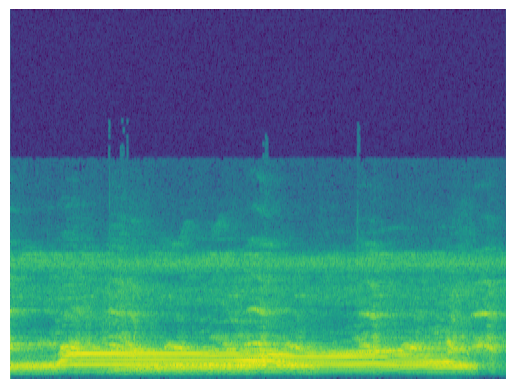

In [23]:
import torchaudio
import matplotlib.pyplot as plt



# 2. Convert to mono (if stereo)
waveform = waveform.mean(dim=0, keepdim=True)

# 3. Compute spectrogram
spec = torchaudio.transforms.Spectrogram()(waveform)

# 4. Convert to dB for better visualization
spec_db = torchaudio.transforms.AmplitudeToDB()(spec)

# 5. Plot and save
plt.imshow(spec_db.squeeze().numpy(), origin='lower', aspect='auto')
plt.axis('off')  # optional: remove axes for cleaner image
plt.savefig("spectrogram_simple.png", dpi=300)
plt.show()

In [47]:
waveform.shape

torch.Size([1, 134240])

In [48]:
waveform

tensor([[ 0.0042,  0.0040,  0.0147,  ..., -0.0488, -0.0553, -0.0523]])

In [49]:
from torch.utils.data import Dataset,DataLoader
import random
device='mps' if torch.backends.mps.is_available() else 'cpu'

In [50]:
len(birdstuples)

217

In [84]:
class getdataset(Dataset):
    def __init__(self,birdstuples,nobirdstuples):
        self.alltuples=birdstuples+nobirdstuples
        random.shuffle(self.alltuples)
    
    def __len__(self):
        return len(self.alltuples)
    def __getitem__(self,ix):
        tupple=self.alltuples[ix]
        embeding,label=tupple
        embeding=torch.tensor(embeding).to(device)
        label=torch.tensor(label).to(device)

        return embeding,label



In [85]:
def collate_fn(batch):
    """Collate function for DataLoader"""
    embeddings, labels = zip(*batch)
    embeddings = torch.stack(embeddings)  # [batch_size, 768]
    labels = torch.tensor(labels, dtype=torch.float32)
    return embeddings, labels

In [86]:
import math

In [87]:
traindataset=getdataset(birdstuples[:math.floor(len(birdstuples)*0.8)],nobirdstuples[:math.floor(len(nobirdstuples)*0.8)])
trainataloader=DataLoader(traindataset,batch_size=8,shuffle=True,collate_fn=collate_fn)
valdataset=getdataset(birdstuples[math.floor(len(birdstuples)*0.8):],nobirdstuples[math.floor(len(nobirdstuples)*0.8):])
valdataloader=DataLoader(traindataset,batch_size=8,shuffle=True,collate_fn=collate_fn)

In [88]:
ds=getdataset(birdstuples,nobirdstuples)
ds[0][0].shape

/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_31201/221680463.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeding=torch.tensor(embeding).to(device)


torch.Size([1, 768])

In [89]:
# waveform=torchaudio.transforms.Resample(orig_freq=sample_rate,new_freq=bundle.sample_rate)

device='mps' if torch.backends.mps.is_available() else 'cpu'

In [90]:
def generateimages(waveform,path):

    waveform = waveform.mean(dim=0, keepdim=True)

# 3. Compute spectrogram
    spec = torchaudio.transforms.Spectrogram()(waveform)

    # 4. Convert to dB for better visualization
    spec_db = torchaudio.transforms.AmplitudeToDB()(spec)

    # 5. Plot and save
    plt.imshow(spec_db.squeeze().numpy(), origin='lower', aspect='auto')
    plt.axis('off')  # optional: remove axes for cleaner image
    plt.savefig("spectrogram_simple.png", dpi=300)
    plt.show()
    

In [26]:
modelc=nn.Sequential(
    nn.Linear(768,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,1),
  
)

In [27]:
from torch.optim import Adam
optimizer=Adam(modelc.parameters(),lr=3e-5)


In [28]:
from torch import nn




In [29]:

loss_fn = torch.nn.BCEWithLogitsLoss()


In [30]:
modelc.to(device)

Sequential(
  (0): Linear(in_features=768, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=128, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): ReLU()
  (8): Linear(in_features=16, out_features=1, bias=True)
)

In [31]:
from torchsummary import summary

In [32]:
summary(modelc)

TypeError: summary() missing 1 required positional argument: 'input_size'

In [119]:
from tqdm import tqdm

/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_31201/221680463.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeding=torch.tensor(embeding).to(device)


Epoch [1/150]
  Train - Loss: 0.7410, Accuracy: 26.74%
  Val   - Loss: 0.7318, Accuracy: 26.99%
--------------------------------------------------
Epoch [2/150]
  Train - Loss: 0.7226, Accuracy: 26.74%
  Val   - Loss: 0.7083, Accuracy: 26.99%
--------------------------------------------------
Epoch [3/150]
  Train - Loss: 0.6963, Accuracy: 36.63%
  Val   - Loss: 0.6698, Accuracy: 86.50%
--------------------------------------------------
Epoch [4/150]
  Train - Loss: 0.6528, Accuracy: 77.74%
  Val   - Loss: 0.6122, Accuracy: 87.73%
--------------------------------------------------
Epoch [5/150]
  Train - Loss: 0.5950, Accuracy: 88.41%
  Val   - Loss: 0.5384, Accuracy: 87.73%
--------------------------------------------------
Epoch [6/150]
  Train - Loss: 0.5264, Accuracy: 85.32%
  Val   - Loss: 0.4601, Accuracy: 85.28%
--------------------------------------------------
Epoch [7/150]
  Train - Loss: 0.4588, Accuracy: 87.33%
  Val   - Loss: 0.3942, Accuracy: 85.89%
----------------------

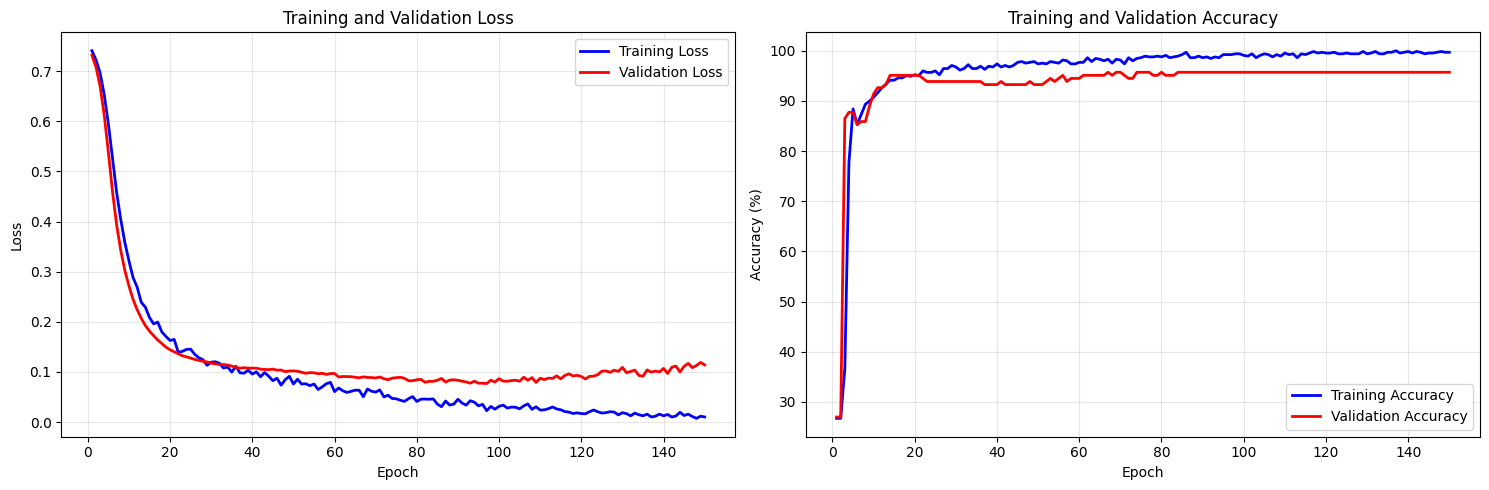

: 

In [ ]:
import torch
import matplotlib.pyplot as plt

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Fixed dataloader setup
traindataset = getdataset(birdstuples[:math.floor(len(birdstuples)*0.8)], nobirdstuples[:math.floor(len(nobirdstuples)*0.8)])
traindataloader = DataLoader(traindataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
valdataset = getdataset(birdstuples[math.floor(len(birdstuples)*0.8):], nobirdstuples[math.floor(len(nobirdstuples)*0.8):])
valdataloader = DataLoader(valdataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

epochs = 150

for epoch in range(epochs):
    # ========== TRAINING PHASE ==========
    modelc.train()
    train_total_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in traindataloader:
        embedding, label = batch
        embedding = embedding.to(device)
        label = label.to(device)
        embedding = embedding.squeeze(1)

        # Forward pass
        output = modelc(embedding)
        loss = loss_fn(output.float().squeeze(1), label.float())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        train_total_loss += loss.item()
        with torch.no_grad():
            preds = torch.round(torch.sigmoid(output.squeeze(1)))
            train_correct += (preds == label).sum().item()
            train_total += label.size(0)

    # ========== VALIDATION PHASE ==========
    modelc.eval()
    val_total_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in valdataloader:
            embedding, label = batch
            embedding = embedding.to(device)
            label = label.to(device)
            embedding = embedding.squeeze(1)

            output = modelc(embedding)
            loss = loss_fn(output.float().squeeze(1), label.float())

            val_total_loss += loss.item()
            preds = torch.round(torch.sigmoid(output.squeeze(1)))
            val_correct += (preds == label).sum().item()
            val_total += label.size(0)

    # Calculate and store metrics
    train_avg_loss = train_total_loss / len(traindataloader)
    train_accuracy = train_correct / train_total * 100
    val_avg_loss = val_total_loss / len(valdataloader)
    val_accuracy = val_correct / val_total * 100

    train_losses.append(train_avg_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_avg_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"  Train - Loss: {train_avg_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    print(f"  Val   - Loss: {val_avg_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
    print("-" * 50)

# ========== PLOTTING RESULTS ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(range(1, epochs + 1), train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(range(1, epochs + 1), val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(range(1, epochs + 1), train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(range(1, epochs + 1), val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [64]:
import torch

labels = []
for _, label in dataloader:
    labels.append(label)
labels = torch.cat(labels)
print(torch.bincount(labels.int()))


/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_31201/221680463.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeding=torch.tensor(embeding).to(device)


tensor([593, 217])
